# de-tiding of a water velocity time series

E. Klein - 2021-10-06

This notebook will perform and compare different filters to remove the tidal component from a water velocity time series.

The filters used are:

- A simple moving average/median
- A FFT low pass filter
- A convolution with a Lanczos cosine window
- The Trenberth filter as described on [Monthly Weather Review, vol. 112, No. 2, Feb 1984](https://journals.ametsoc.org/search?access=all&f_0=author&f_1=date&o_1=AND&q_0=Trenberth&q_1=%257BEXACT_DATE%253D%253D1984%257D&type_0=journalarticle).
- PL33 filter is described on p. 21, [Rosenfeld (1983), WHOI Technical Report 85-35](https://darchive.mblwhoilibrary.org/handle/1912/1641).



### Data read and visualsation

The data comes from an ADCP sensor at NRS Yongala

In [25]:
## imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from builtins import format

import oceans.filters as oc



In [2]:
## get file
fileName = 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NRS/NRSYON/Velocity/IMOS_ANMN-NRS_AETVZ_20200612T225300Z_NRSYON_FV01_NRSYON-2006-SUB-Sentinel-or-Monitor-Workhorse-ADCP-28.1_END-20201207T001000Z_C-20210921T023431Z.nc'
nc = xr.open_dataset(fileName)

In [3]:
## look at the data variables: 
nc.data_vars

Data variables:
    TIMESERIES                  int32 ...
    TEMP                        (TIME) float32 ...
    TEMP_quality_control        (TIME) float32 ...
    PRES_REL                    (TIME) float32 ...
    PRES_REL_quality_control    (TIME) float32 ...
    SSPD                        (TIME) float32 ...
    SSPD_quality_control        (TIME) float32 ...
    PITCH                       (TIME) float32 ...
    PITCH_quality_control       (TIME) float32 ...
    ROLL                        (TIME) float32 ...
    ROLL_quality_control        (TIME) float32 ...
    HEADING                     (TIME) float32 ...
    HEADING_quality_control     (TIME) float32 ...
    TX_CURRENT                  (TIME) float32 ...
    TX_CURRENT_quality_control  (TIME) float32 ...
    TX_VOLT                     (TIME) float32 ...
    TX_VOLT_quality_control     (TIME) float32 ...
    DEPTH                       (TIME) float32 ...
    DEPTH_quality_control       (TIME) float32 ...
    UCUR                

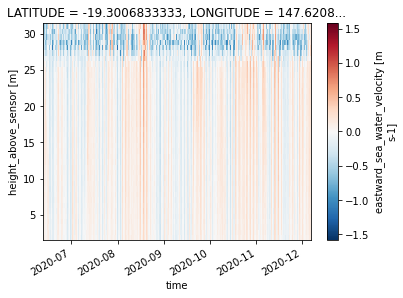

In [4]:
nc.UCUR.T.plot()

In [5]:
## extract UCUR, good data only
UCUR = nc.UCUR.where((nc.UCUR_quality_control<=2), drop=True)

In [6]:
UCUR

<xarray.DataArray 'UCUR' (TIME: 25483, HEIGHT_ABOVE_SENSOR: 35)>
array([[-0.001, -0.057, -0.023, ..., -0.042,    nan,    nan],
       [-0.003, -0.002,  0.03 , ...,    nan,    nan,    nan],
       [-0.002,  0.001, -0.007, ...,    nan,    nan,    nan],
       ...,
       [ 0.088,  0.101,  0.09 , ...,    nan,    nan,    nan],
       [ 0.069,  0.12 ,  0.122, ...,    nan,    nan,    nan],
       [ 0.104,  0.135,  0.184, ...,    nan,    nan,    nan]],
      dtype=float32)
Coordinates:
  * TIME                 (TIME) datetime64[ns] 2020-06-12T22:58:59.999996928 ...
  * HEIGHT_ABOVE_SENSOR  (HEIGHT_ABOVE_SENSOR) float32 1.87 2.62 ... 26.62 27.37
    LATITUDE             float64 -19.3
    LONGITUDE            float64 147.6
    NOMINAL_DEPTH        float32 28.1
Attributes:
    ancillary_variables:         UCUR_quality_control
    comment:                     A compass correction of 7.58degrees has been...
    compass_correction_applied:  7.58
    long_name:                   eastward_sea_water_velocity
    magnetic_declination:        7.55
    reference_datum:             true north
    standard_name:               eastward_sea_water_velocity
    units:                       m s-1
    valid_max:                   10.0
    valid_min:                   -10.0
    _ChunkSizes:                 [25577    40]

Let's see how many cells are registered:

In [7]:
nc.HEIGHT_ABOVE_SENSOR.values

array([ 1.87,  2.62,  3.37,  4.12,  4.87,  5.62,  6.37,  7.12,  7.87,
        8.62,  9.37, 10.12, 10.87, 11.62, 12.37, 13.12, 13.87, 14.62,
       15.37, 16.12, 16.87, 17.62, 18.37, 19.12, 19.87, 20.62, 21.37,
       22.12, 22.87, 23.62, 24.37, 25.12, 25.87, 26.62, 27.37, 28.12,
       28.87, 29.62, 30.37, 31.12], dtype=float32)

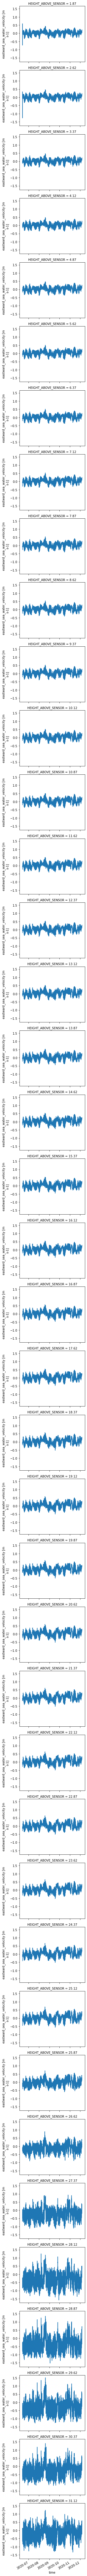

In [8]:
nc.UCUR.plot(row="HEIGHT_ABOVE_SENSOR")

Let's select one cell near the sensor, e.g. at 4.87m:

In [9]:
UCUR = UCUR.where(UCUR.HEIGHT_ABOVE_SENSOR == 4.87, drop = True)
print(UCUR)


<xarray.DataArray 'UCUR' (TIME: 25483, HEIGHT_ABOVE_SENSOR: 1)>
array([[-0.008],
       [-0.011],
       [-0.03 ],
       ...,
       [ 0.121],
       [ 0.138],
       [ 0.172]], dtype=float32)
Coordinates:
  * TIME                 (TIME) datetime64[ns] 2020-06-12T22:58:59.999996928 ...
  * HEIGHT_ABOVE_SENSOR  (HEIGHT_ABOVE_SENSOR) float32 4.87
    LATITUDE             float64 -19.3
    LONGITUDE            float64 147.6
    NOMINAL_DEPTH        float32 28.1
Attributes:
    ancillary_variables:         UCUR_quality_control
    comment:                     A compass correction of 7.58degrees has been...
    compass_correction_applied:  7.58
    long_name:                   eastward_sea_water_velocity
    magnetic_declination:        7.55
    reference_datum:             true north
    standard_name:               eastward_sea_water_velocity
    units:                       m s-1
    valid_max:                   10.0
    valid_min:                   -10.0
    _ChunkSizes:               

As the data is collected every 10 minutes, let's average to the hour:

## Filter out the tides

First get 1D HOURLY arrays for TIME and UCUR (already selected at one `HEIGTH_ABOVE_SENSOR`):

In [10]:
UCURhour = UCUR.resample(TIME='1H').mean()

In [11]:
time = UCURhour.TIME.values
uu = UCURhour.values[:,0]
print(time.shape)
print(uu.shape)

(4251,)
(4251,)


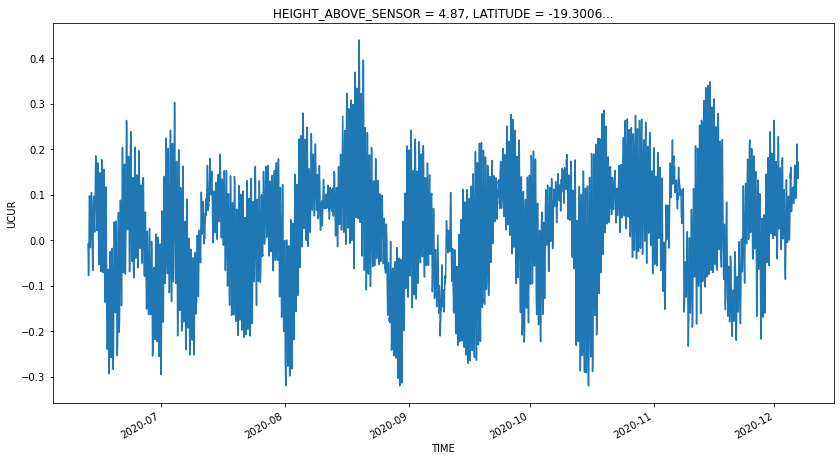

In [12]:
UCURhour.plot(aspect=2, size=7)

The spectral density of the series: 

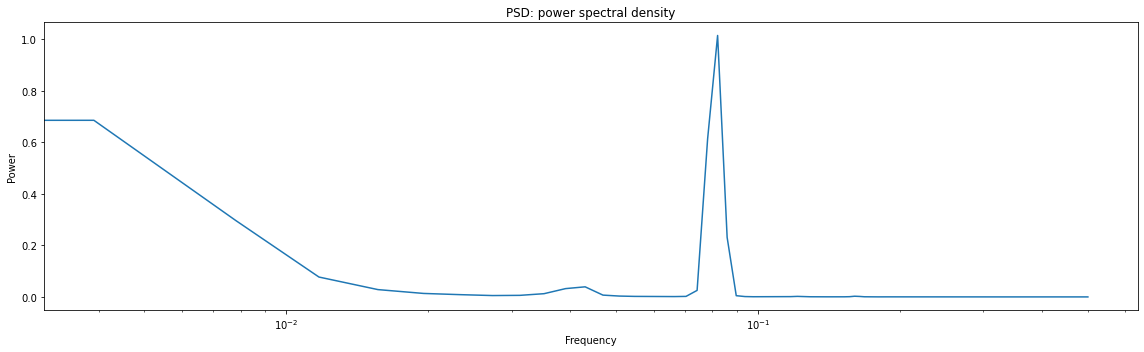

In [63]:
freqs, psd = signal.welch(UCURhour.values[:,0])


plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

The series show a strong signal at ~12h and ~24h


-------------------------------------------

## Moving average window

Performs a discrete one-dimensional median filter with window length L to input vector x. Produces a vector the same size as x. Boundaries are handled by shrinking L at edges; no data outside of x is used in producing the median filtered output.

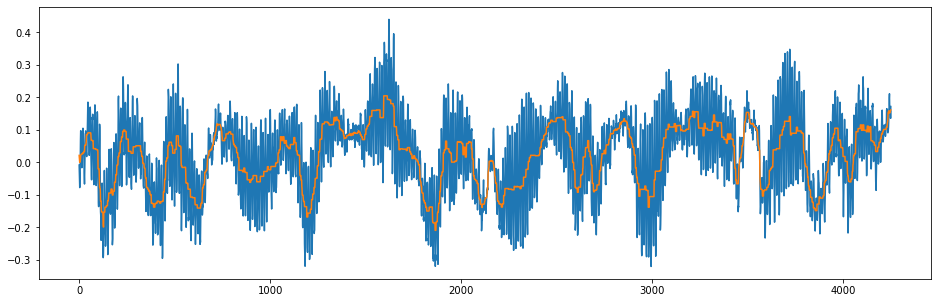

In [13]:
L = 24   ## 24 hours windows
UCURmed = oc.medfilt1(uu, L)

plt.rcParams['figure.figsize'] = (16,5)
plt.plot(uu)
plt.plot(UCURmed)

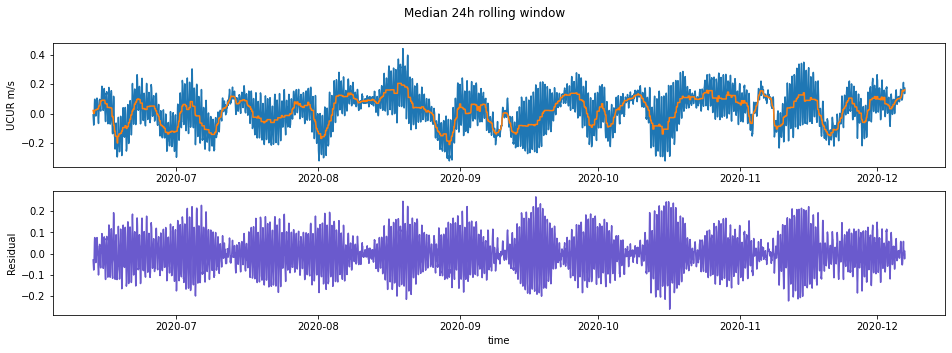

In [143]:
plt.rcParams['figure.figsize'] = (16,5)


fig, (ax1, ax3) = plt.subplots(2, 1)
fig.suptitle('Median 24h rolling window')

ax1.plot(time, uu, '-')
ax1.set_ylabel('UCUR m/s')
ax1.plot(time, UCURmed, '-')

ax3.plot(time, uu-UCURmed, '-', color='slateblue')
ax3.set_xlabel('time')
ax3.set_ylabel('Residual')

plt.show()

Autocorrelation of the difference: 

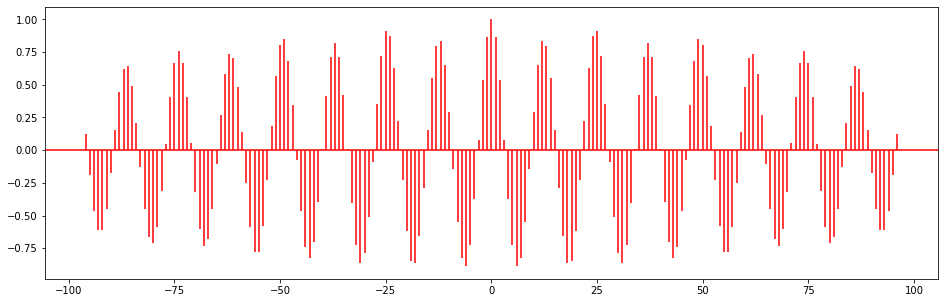

In [77]:
acor = plt.acorr(uu-UCURmed, color='r', maxlags=96)

Spectral density estimate

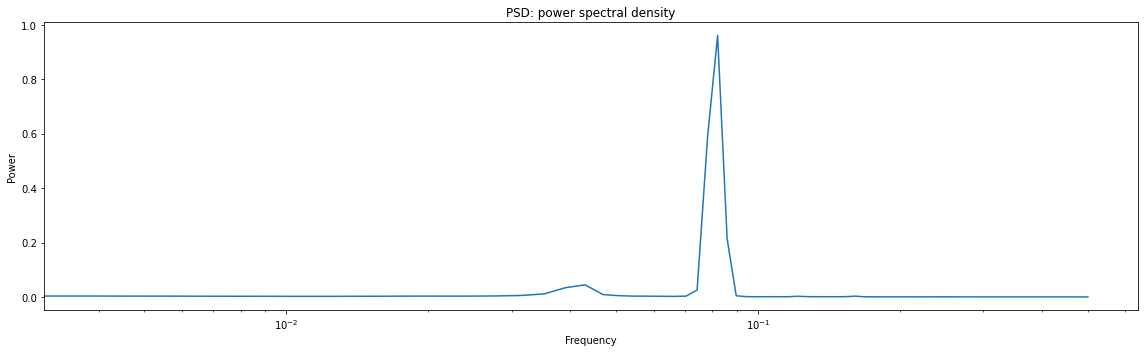

In [18]:
freqs, psd = signal.welch(uu - UCURmed)


plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [56]:
#zip(*sorted(zip(psd, freqs)))[0]
topFive = np.argsort(-psd)[:5]
print(1/freqs[topFive])

[12.19047619 12.8        11.63636364 23.27272727 25.6       ]


In [39]:
print(max(psd), freqs[np.argmax(psd)])
print(1/freqs[np.argmax(psd)])

0.9608743 0.08203125
12.19047619047619


The filtered series retains a very string signal at ~12 and ~24h

--------------------------------------------



## FFT low pass
Performs a low pass filer on the series. Low and high specifies the boundary of the filter.

In [66]:
UCURlp = oc.fft_lowpass(uu, low=1/30, high=1/40)

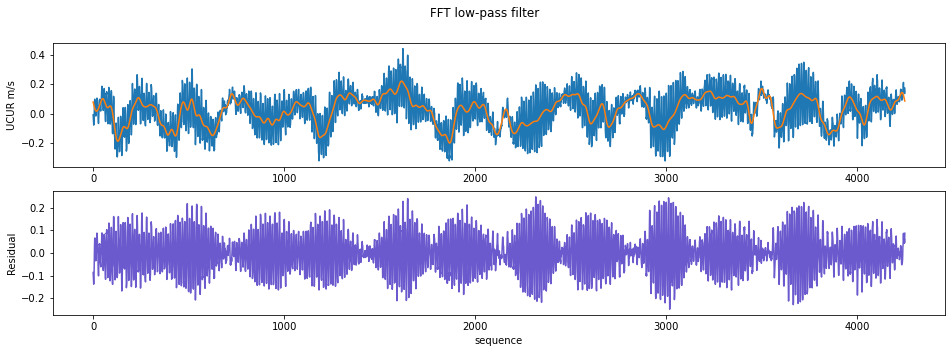

In [142]:
fig, (ax1, ax3) = plt.subplots(2, 1)
fig.suptitle('FFT low-pass filter')

ax1.plot(uu, '-')
ax1.set_ylabel('UCUR m/s')
ax1.plot(UCURlp, '-')

ax3.plot(uu-UCURlp, '-', color='slateblue')
ax3.set_xlabel('sequence')
ax3.set_ylabel('Residual')

plt.show()

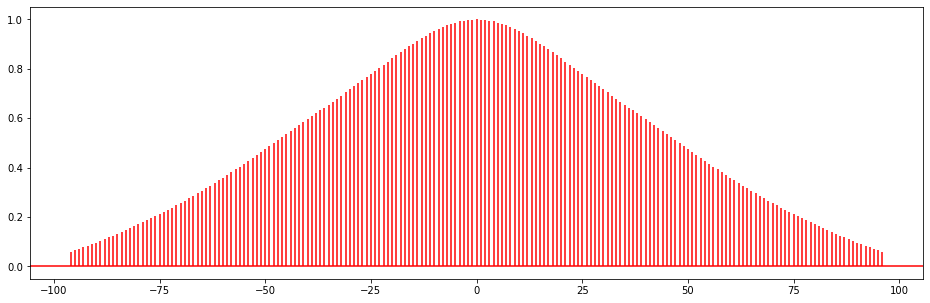

In [76]:
acorr = plt.acorr(UCURlp, color='r', maxlags=96)

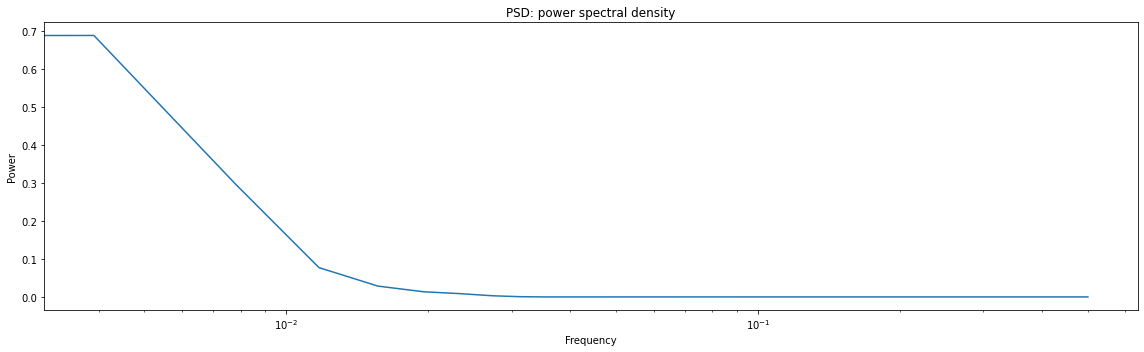

In [72]:
freqs, psd = signal.welch(UCURlp)


plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

-----------------------------

## Lanczos Cosine + convolution



In [81]:
wt = oc.lanc(96+1+96, 1./40)
UCURlanczos = np.convolve(wt,uu, mode='same')

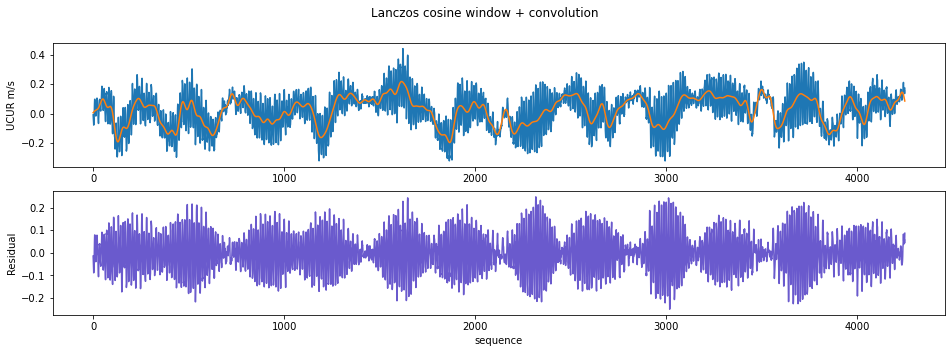

In [141]:
fig, (ax1, ax3) = plt.subplots(2, 1)
fig.suptitle('Lanczos cosine window + convolution')

ax1.plot(uu, '-')
ax1.set_ylabel('UCUR m/s')
ax1.plot(UCURlanczos, '-')

ax3.plot(uu-UCURlanczos, '-', color='slateblue')
ax3.set_xlabel('sequence')
ax3.set_ylabel('Residual')

plt.show()

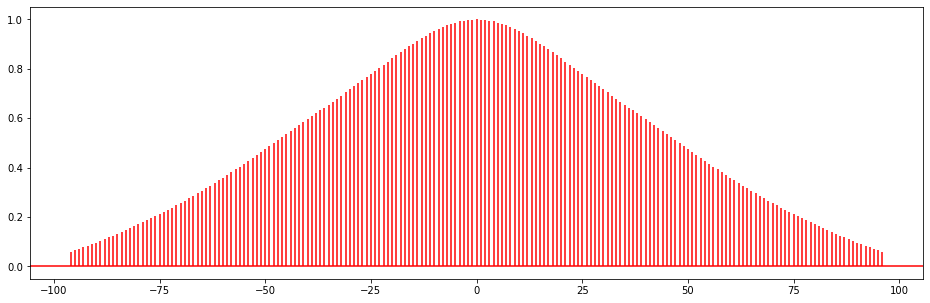

In [84]:
acorr = plt.acorr(UCURlp, color='r', maxlags=96)

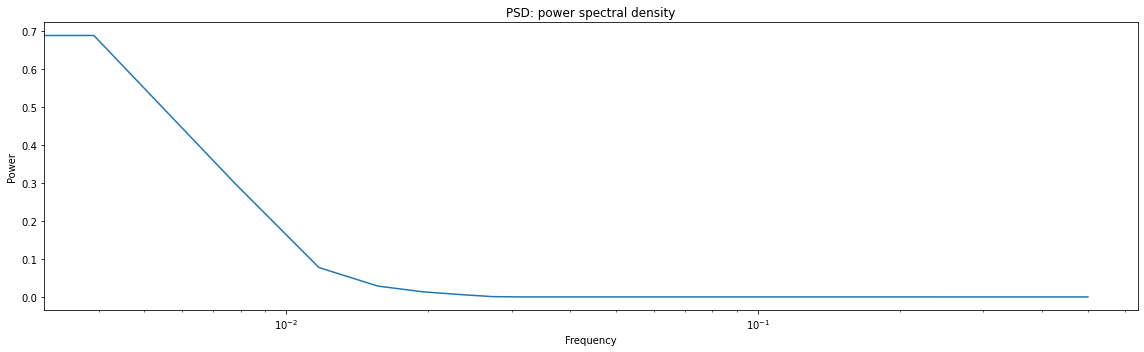

In [83]:
freqs, psd = signal.welch(UCURlanczos)


plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

---------------------------------


## Tremberth

In [85]:
UCURtremberth = oc.md_trenberth(uu)

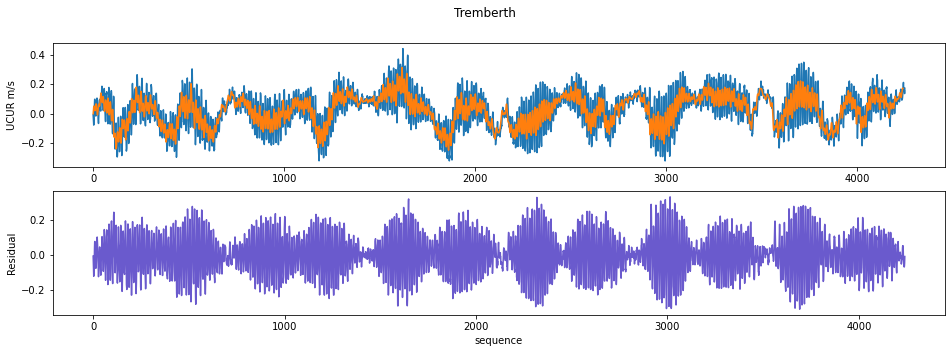

In [140]:
fig, (ax1, ax3) = plt.subplots(2, 1)
fig.suptitle('Tremberth')

ax1.plot(uu, '-')
ax1.set_ylabel('UCUR m/s')
ax1.plot(UCURtremberth, '-')

ax3.plot(uu[:-10] - UCURtremberth, '-', color='slateblue')
ax3.set_xlabel('sequence')
ax3.set_ylabel('Residual')

plt.show()

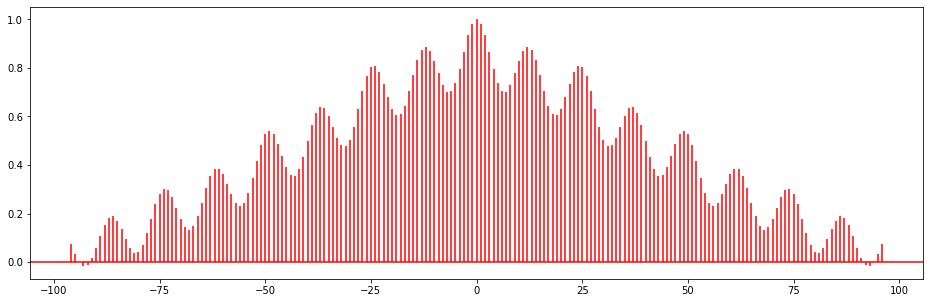

In [91]:
acorr = plt.acorr(UCURtremberth, color='r', maxlags=96)

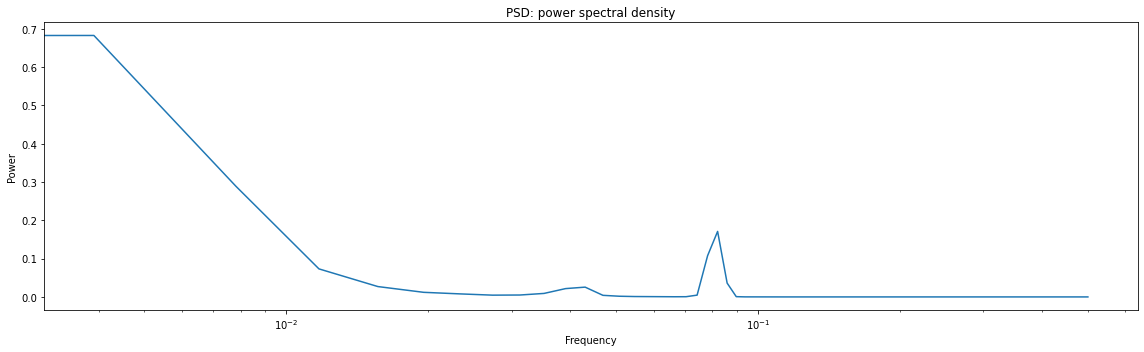

In [93]:
freqs, psd = signal.welch(UCURtremberth)


plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

-----------------------------------------------


## PL33


Filter by 3 days:


In [126]:
UCURpl33d3 = oc.pl33tn(uu, dt=4.0, T=72)
print(UCURpl33d3.shape)
print((uu.shape))

(4217,)
(4251,)


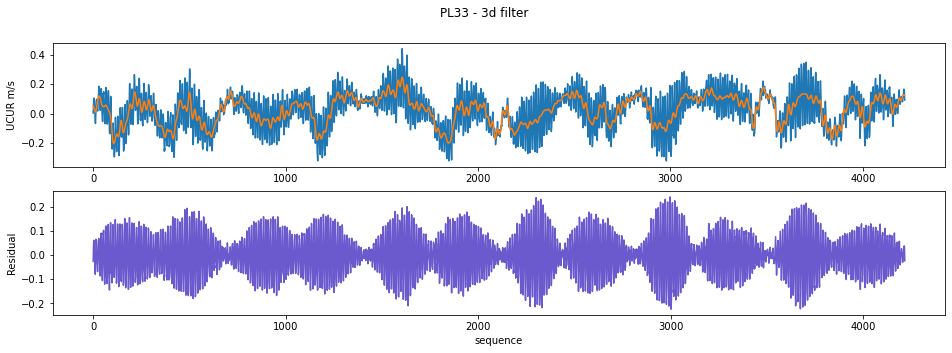

In [139]:
fig, (ax1, ax3) = plt.subplots(2, 1)
fig.suptitle('PL33 - 3d filter')

ax1.plot(uu[16:-16], '-')
ax1.set_ylabel('UCUR m/s')
ax1.plot(UCURpl33d3, '-')

ax3.plot(uu[17:-17] - UCURpl33d3, '-', color='slateblue')
ax3.set_xlabel('sequence')
ax3.set_ylabel('Residual')

plt.show()

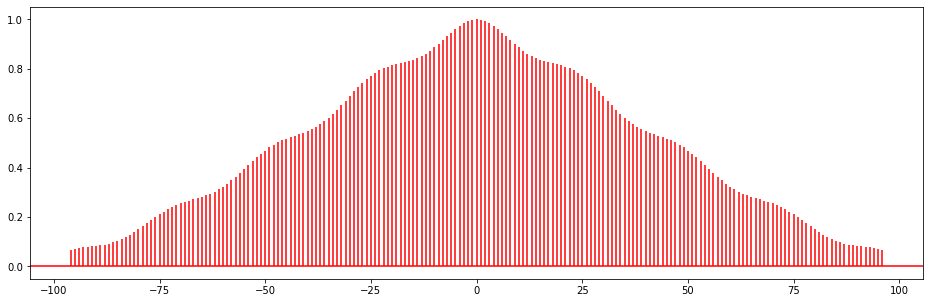

In [116]:
acorr = plt.acorr(UCURpl33d3, color='r', maxlags=96)

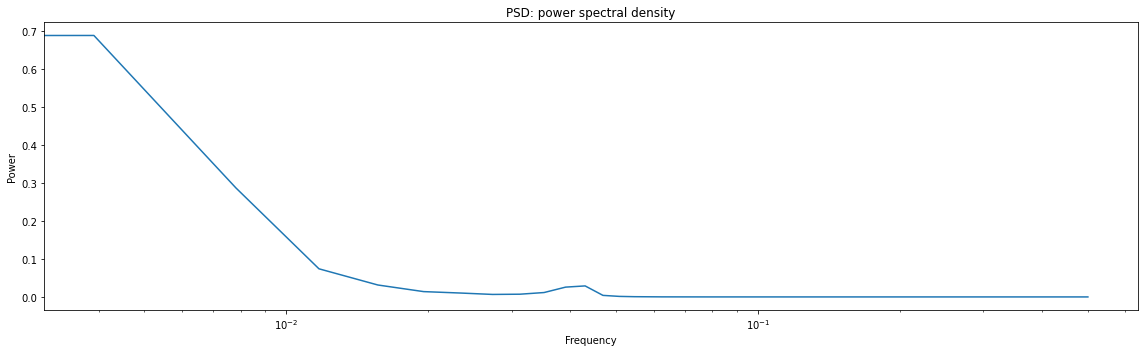

In [119]:
freqs, psd = signal.welch(UCURpl33d3)


plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

------------------------------------

## CONCLUSION 

The analysis of the spectral density function will give us the view of the removal of the 12-24h periods, associated with tides. The FFT low-pass filter and the Lanczos-Cosine Window produced a "clean" spectrogram. Both filters could be parametrised to obtain the desiring filtering. Thompson & Emery (2014) suggested that the Lanczos windows is better at reducing side-lobe ripples, hence the contamination of the original signal with un-filtered, remaining frequencies.

Below, a section of the UCUR record with a Lanczos filter (orange) and FFT low pass (green) resulting time series. Note almost perfect match of the two filtering methods.

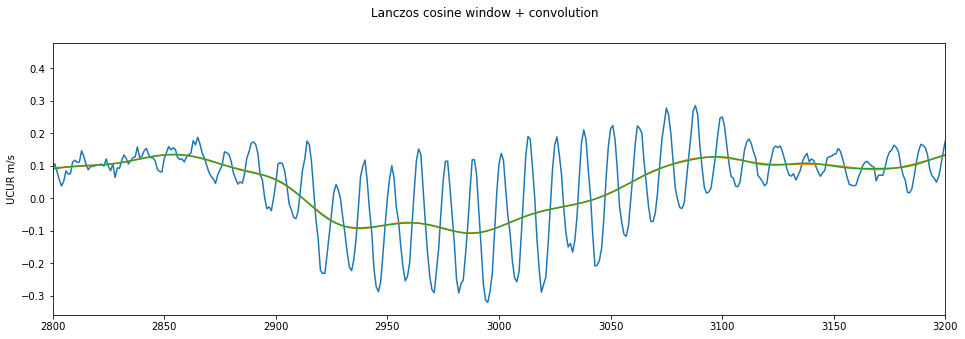

In [151]:
fig, ax1 = plt.subplots(1, 1)
fig.suptitle('Lanczos cosine window + convolution')

ax1.plot(uu, '-')
ax1.set_ylabel('UCUR m/s')
ax1.plot(UCURlanczos, '-')
ax1.plot(UCURlp, '-')
ax1.set_xlim(2800, 3200)

plt.show()